# Example 5.4 (Simultaneous confidence intervals as shadows of the confidence ellipse)

In [1]:
import pathlib
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse

In [2]:
def load_data() -> pd.DataFrame:
    """
    Load the microwave radiation data from Example 5.3 and Example 5.4.
    """
    closed_pth = pathlib.Path('..\..\data\Table4.1.xlsx')
    closed_df = pd.read_excel(closed_pth, names=['Oven', 'ClosedRadiation'])

    open_pth = pathlib.Path('..\..\data\Table4.5.xlsx')
    open_df = pd.read_excel(open_pth, names=['Oven', 'OpenRadiation'])

    return closed_df.merge(open_df).set_index('Oven')**(1/4)

In [3]:
radiation_df = load_data()
radiation_df.head(3)

,ClosedRadiation,OpenRadiation
Oven,,
1,0.622333,0.740083
2,0.547723,0.547723
3,0.651356,0.740083


In [34]:
def compute_simultaneous_ci(df: pd.DataFrame, alpha: float) -> np.array:
    n, p = df.shape

    xbar = np.mean(df, axis=0).to_numpy().reshape(p,1)
    S = np.var(df).to_numpy().reshape(p,1)

    # Upper tail.
    const = (p*(n-1))/(n*(n-p))
    f_val = const * scipy.stats.f.ppf(q=1-alpha, dfn=p, dfd=n-p)
    return xbar + np.array([-1, 1]) * np.sqrt(f_val*S)

In [36]:
simul_ci = compute_simultaneous_ci(radiation_df, alpha=0.05)
simul_ci

In [61]:
def plot_confidence_ellipse(df: pd.DataFrame, alpha: float):
    xbar = np.mean(df, axis=0).to_numpy()
    n, p = radiation_df.shape

    eigenvalues, eigenvectors = np.linalg.eig(np.cov(df.T))
    max_idx, min_idx = np.argmax(eigenvalues), np.argmin(eigenvalues)
    lmbda1, lmbda2 = eigenvalues[max_idx], eigenvalues[min_idx]
    e1, e2 = eigenvectors[:, max_idx].copy(), eigenvectors[:, min_idx].copy()

    const = (p*(n - 1))/(n*(n - p))
    f_val = scipy.stats.f.ppf(1-alpha,p,n-p)

    if np.all(e1 < 0):
        e1 = e1*(-1)

    ell_width = np.sqrt(lmbda1)*np.sqrt(const*f_val)
    ell_height = np.sqrt(lmbda2)*np.sqrt(const*f_val)
    ell_angle = np.arccos(e1[1])*(180/np.pi)

    plt.figure()
    ax = plt.gca()
    ellipse = Ellipse(xy=xbar,
                      width=2*ell_width,
                      height=2*ell_height,
                      angle=ell_angle,
                      fill=False)
    ax.add_patch(ellipse)
    for i in [-1, 1]:
        plt.quiver(xbar[0],
                xbar[1],
                e1[0] * ell_width * i,
                e1[1] * ell_width * i,
                angles='xy',
                scale_units='xy',
                scale=1
                )
        plt.quiver(xbar[0],
                xbar[1],
                e2[0] * ell_height * i,
                e2[1] * ell_height * i,
                angles='xy',
                scale_units='xy',
                scale=1)
    return plt, ax

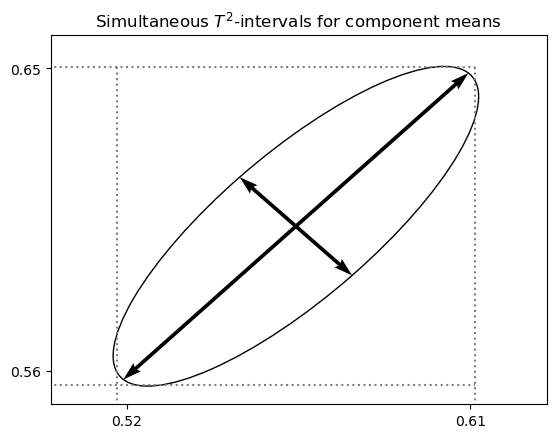

In [73]:
xbar = np.mean(radiation_df, axis=0)
my_plot, ax = plot_confidence_ellipse(radiation_df, alpha=0.05)
ax.set_title('Simultaneous $T^{2}$-intervals for component means')
my_plot.xlim([0.50, 0.63])
my_plot.ylim([0.55, 0.66])

# Draw dashed lines at the simultaneous T^2 values (closed).
ax.plot([simul_ci[0,0], simul_ci[0,0]], [0, simul_ci[1,1]], linestyle=':', color='gray')
ax.plot([simul_ci[0,1], simul_ci[0,1]], [0, simul_ci[1,1]], linestyle=':', color='gray')

# Draw dashed lines at the simultaneous T^2 values (open).
ax.plot([0, simul_ci[0,1]], [simul_ci[1,1], simul_ci[1,1]], linestyle=':', color='gray')
ax.plot([0, simul_ci[0,1]], [simul_ci[1,0], simul_ci[1,0]], linestyle=':', color='gray')

# Label simultaneous CI on the axis.
ax.set_xticks(np.round(simul_ci[0,:], 2))
ax.set_yticks(np.round(simul_ci[1,:], 2))

my_plot.show()